# FCC Security Recommendations: NLP Model

In [1]:
# Imports!
# We likely will not end up using all of these, but better to have & not need.

import pickle       # Imports pickle if we want to save the model for later
import regex as re  # Imports Regex
import pandas as pd # Imports Pandas
import numpy as np  # Imports NumPy
import scipy as sp  # Imports SciPy
import seaborn as sns # Imports Seaborn
import gensim

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes
from sklearn.feature_extraction import stop_words
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Loads in the csv file through the Pandas library & allows us to view it.
fcc_csv = pd.read_csv('./data/CSRIC_Best_Practices.csv')

## Exploratory Analysis & Data Cleaning

In [3]:
# Here's a function to convert NaN's in the data set to 'None' for string objects.
# Just pass in the entire data frame.
def convert_str_nan(data):
    return data.replace(np.nan, 'None', inplace = True)
convert_str_nan(fcc_csv)

# Here's a function to drop any rows with NaN's in the dataset.
# Just pass in the entire data frame.
def drop_nans(data):
    return data.dropna()
drop_nans(fcc_csv).head()

,BP Number,Priority,Description,Network Type(s),Industry Role(s),Keywords,Reference,cable,internet/Data,satellite,wireless,wireline,Service Provider,Network Operator,"Priority (1,2,3)",Equipment Supplier,Property Manager,Government,Public Safety
0,11-10-0404,Important,"Service Providers, Network Operators, Public S...",Cable; Internet/Data; Satellite; Wireless; Wir...,Equipment Supplier; Network Operator; Service ...,Hardware; Network Design; Network Elements; Ne...,None,True,True,True,True,True,True,True,1,True,False,False,True
1,11-10-0407,Highly Important,Network Operators and Service Providers should...,Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider;,Industry Cooperation; Network Interoperability...,None,True,True,True,True,True,True,True,2,False,False,False,False
2,11-10-0409,Highly Important,Service Providers should use virtual interface...,Internet/Data;,Service Provider;,Network Design; Network Elements;,None,False,True,False,False,False,True,False,2,False,False,False,False
3,11-10-0411,Highly Important,"Network Operators, Service Providers, and Publ...",Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider; Public Saf...,Network Operations; Facilities - Transport;,None,True,True,True,True,True,True,True,2,False,False,False,True
4,11-10-0418,Highly Important,"Network Operators, Service Providers, and Publ...",Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider; Public Saf...,Network Operations; Procedures;,Note: This Best practice could impact 9-1-1 op...,True,True,True,True,True,True,True,2,False,False,False,True


In [4]:
# Gives us a list of all the column names within the data frame.
fcc_csv.columns

Index(['BP Number', 'Priority', 'Description', 'Network Type(s)',
       'Industry Role(s)', 'Keywords', 'Reference', 'cable', 'internet/Data',
       'satellite', 'wireless', 'wireline', 'Service Provider',
       'Network Operator', 'Priority (1,2,3)', 'Equipment Supplier',
       'Property Manager', 'Government', 'Public Safety'],
      dtype='object')

In [5]:
# Let's rename the 'Priority (1,2,3)' column so we can utilize it.
fcc_csv.rename(columns = {
    'Priority (1,2,3)': 'Priorities'
},
inplace = True)

# Let's view the values & how the correspond to the 'Priority' column.
fcc_csv['Priorities'].value_counts()

1    468
2    356
3    192
Name: Priorities, dtype: int64

## Regex

In [6]:
# Let's clean the data using Regex.
# Let's use regex to remove the words: service providers, equipment suppliers, network operators, property managers, public safety
# Let's also remove any mention of any URLs.
fcc_csv['Description'] = fcc_csv.Description.map(lambda x: re.sub('\s[\/]?r\/[^s]+', ' ', x))
fcc_csv['Description'] = fcc_csv.Description.map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))
fcc_csv['Description'] = fcc_csv.Description.map(lambda x: re.sub('(service providers|equipment suppliers|network operators|property managers|public safety)[s]?', ' ', x,  flags = re.I))

## Preprocessing, Tokenization, Lemmatization, Stemming & Word Count Visualization

### Preprocessing

In [7]:
# This is a text preprocessing function that gets our data ready for modeling & creates new columns for the 
    # description text in their tokenized, lemmatized & stemmed forms. This allows for easy selection of 
    # different forms of the text for use in vectorization & modeling.

def preprocessed_columns(dataframe = fcc_csv, 
                        column = 'Description', 
                        new_lemma_column = 'lemmatized', 
                        new_stem_column = 'stemmed',
                        new_token_column = 'tokenized',
                        regular_expression = r'\w+'): 
    
    tokenizer = RegexpTokenizer(regular_expression)      # Instantiate tokenizer w/ specific regular expression
    lemmatizer = WordNetLemmatizer()                     # Instantiate lemmatizer
    stemmer = PorterStemmer()                            # Instantiate stemmer
    
    lemmatized = []                                      # List to append lemmatized data
    stemmed = []                                         # List to append stemmed words
    tokenized = []
    
    
    for i in dataframe[column]:                          # Iterate through all rows in a specific column

        tokens = tokenizer.tokenize(i.lower())           # Converts string titles to tokens 
        tokenized.append(tokens)

        lemma = [lemmatizer.lemmatize(token) for token in tokens]     # Lemmatizes all tokens
        lemmatized.append(lemma)                                      # Appends the lemma to a lemmatized list

        stems = [stemmer.stem(token) for token in tokens]             # Stemming all tokens
        stemmed.append(stems)                                         # Creating stem list
     
    dataframe[new_token_column] = [' '.join(i) for i in tokenized]    
    dataframe[new_lemma_column] = [' '.join(i) for i in lemmatized]   # Rejoing the lists for each title
    dataframe[new_stem_column] = [' '.join(i) for i in stemmed]       # Setting results to be new columns in df   
    
    return dataframe

In [8]:
processed = preprocessed_columns()
processed.head()

,BP Number,Priority,Description,Network Type(s),Industry Role(s),Keywords,Reference,cable,internet/Data,satellite,...,Service Provider,Network Operator,Priorities,Equipment Supplier,Property Manager,Government,Public Safety,tokenized,lemmatized,stemmed
0,11-10-0404,Important,", , , and should incorporate methodologie...",Cable; Internet/Data; Satellite; Wireless; Wir...,Equipment Supplier; Network Operator; Service ...,Hardware; Network Design; Network Elements; Ne...,None,True,True,True,...,True,True,1,True,False,False,True,and should incorporate methodologies that cont...,and should incorporate methodology that contin...,and should incorpor methodolog that continu im...
1,11-10-0407,Highly Important,and should establish processes for NOC-to-...,Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider;,Industry Cooperation; Network Interoperability...,None,True,True,True,...,True,True,2,False,False,False,False,and should establish processes for noc to noc ...,and should establish process for noc to noc ne...,and should establish process for noc to noc ne...
2,11-10-0409,Highly Important,should use virtual interfaces (i.e. a router...,Internet/Data;,Service Provider;,Network Design; Network Elements;,None,False,True,False,...,True,False,2,False,False,False,False,should use virtual interfaces i e a router loo...,should use virtual interface i e a router loop...,should use virtual interfac i e a router loopb...
3,11-10-0411,Highly Important,", , and should consider developing and imp...",Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider; Public Saf...,Network Operations; Facilities - Transport;,None,True,True,True,...,True,True,2,False,False,False,True,and should consider developing and implementin...,and should consider developing and implementin...,and should consid develop and implement cabl l...
4,11-10-0418,Highly Important,", , and should, where appropriate, have a ...",Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider; Public Saf...,Network Operations; Procedures;,Note: This Best practice could impact 9-1-1 op...,True,True,True,...,True,True,2,False,False,False,True,and should where appropriate have a documented...,and should where appropriate have a documented...,and should where appropri have a document back...


In [9]:
# We notice that we have an unbalanced classification problem.
# Let's group the "Highly Important" (2) & "Critical" (3) aspects because that's where we can make recommendations.
# Let's double check that it worked.
fcc_csv['Priorities'] = [0 if i == 1 else 1 for i in fcc_csv['Priorities']]
fcc_csv['Priorities'].value_counts()

1    548
0    468
Name: Priorities, dtype: int64

### Countvectorizer

In [10]:
# Instantiate a CountVectorizer removing english stopwords, ngram range of unigrams & bigrams.

cv = CountVectorizer(stop_words = 'english', ngram_range = (1,2), min_df = 25, max_df = .95)

# Create a dataframe of our CV transformed tokenized words
cv_df_token = pd.SparseDataFrame(cv.fit_transform(processed['tokenized']), columns = cv.get_feature_names())
cv_df_token.fillna(0, inplace = True)

cv_df_token.head()

,access,access control,address,analysis,applications,appropriate,associated,authentication,available,based,...,traffic,unauthorized,use,used,user,users,using,vulnerabilities,wireless,work
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


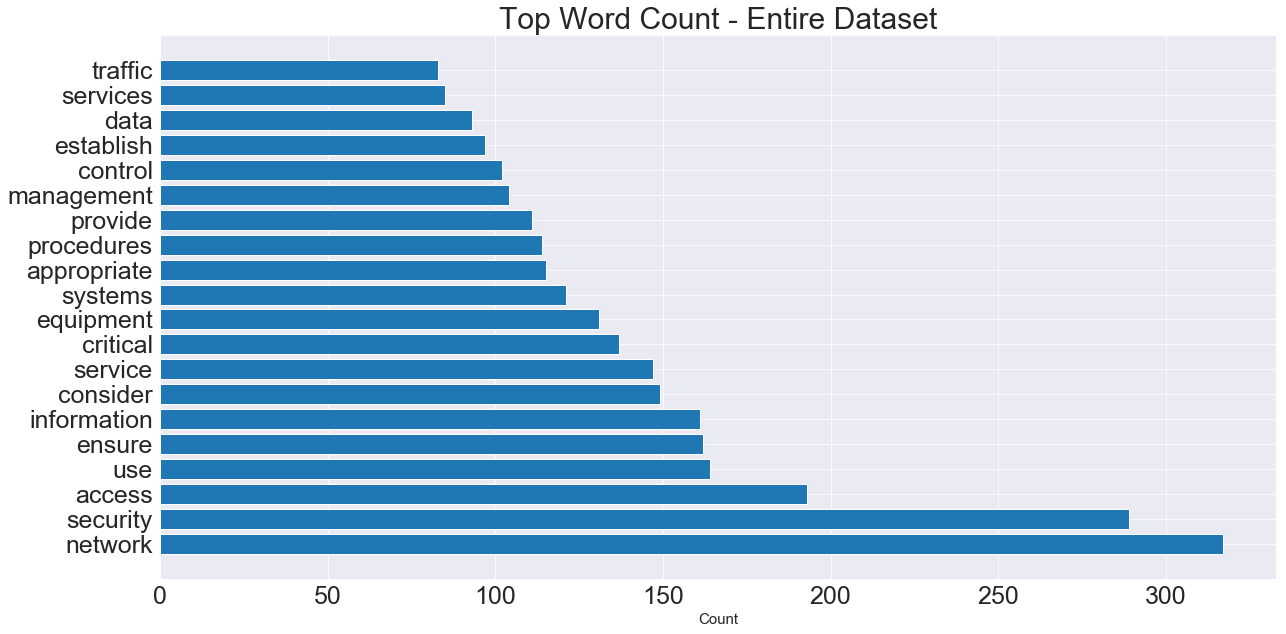

In [11]:
# Visualize the top occurring words in our descriptions column correlation to the priority.
plt.figure(figsize = (20, 10))
plt.barh(y = cv_df_token.sum().sort_values(ascending = False).head(20).index, width = cv_df_token.sum().sort_values(ascending = False).head(20))
plt.title('Top Word Count - Entire Dataset', fontsize = 30)
plt.xlabel('Count', fontsize = 15)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25);

In [12]:
# Split our data frame into really "important" & "not important" columns.
# We will use the "really_important" descriptions to determine severity & to give recommendations/analysis.
fcc_really_important = processed[processed['Priorities'] == 1]
fcc_not_important = processed[processed['Priorities'] == 0]

print(fcc_really_important.shape)
print(fcc_not_important.shape)

(548, 22)
(468, 22)


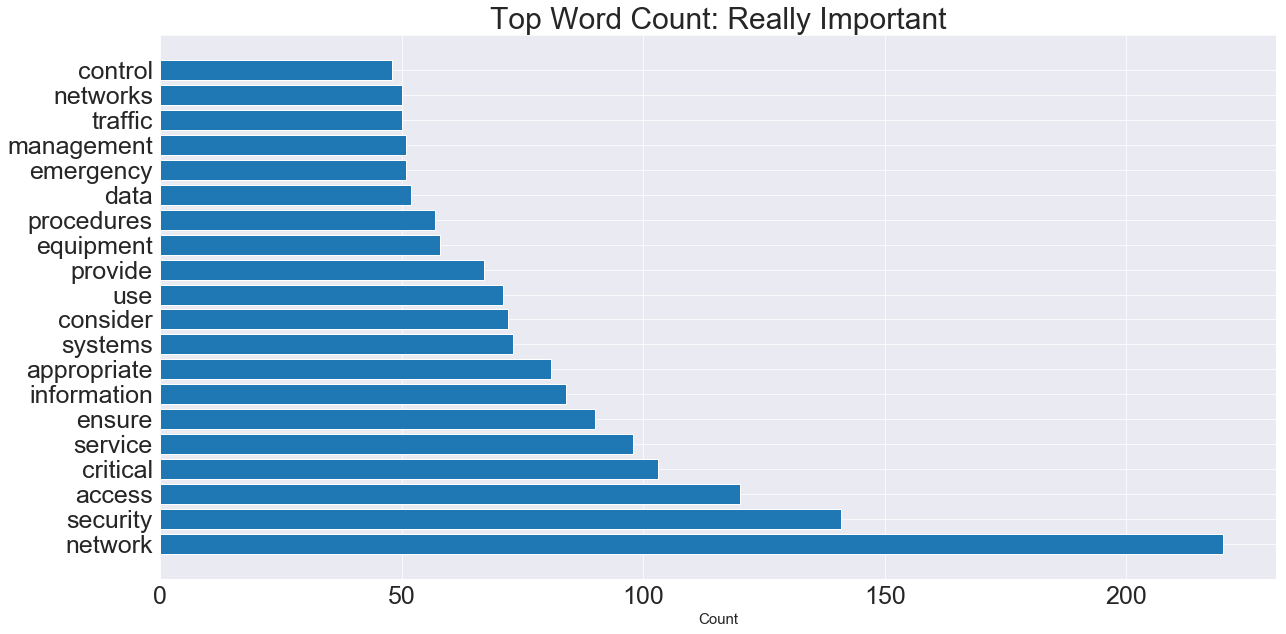

In [13]:
# Create our dataframe of features obtained from our CountVectorizer.
cv_fcc_really_important_token = pd.SparseDataFrame(cv.fit_transform(fcc_really_important['tokenized']), columns = cv.get_feature_names())
cv_fcc_really_important_token.fillna(0, inplace = True)

# Plot top 20 "really_important" features.
plt.figure(figsize = (20, 10))
plt.barh(y = cv_fcc_really_important_token.sum().sort_values(ascending = False).head(20).index, width = cv_fcc_really_important_token.sum().sort_values(ascending = False).head(20))
plt.title('Top Word Count: Really Important', fontsize = 30)
plt.xlabel('Count', fontsize = 15)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25);

### Lemmatization

In [14]:
# This is the same thing we did above but for lemmatized words rather than tokenized words.
cv_lem = CountVectorizer(stop_words = 'english', ngram_range = (1,2), min_df = 25, max_df = .95)

cv_df_lem = pd.SparseDataFrame(cv_lem.fit_transform(processed['lemmatized']), columns = cv_lem.get_feature_names())
cv_df_lem.fillna(0, inplace = True)
cv_df_lem.head()

,access,access control,activity,address,analysis,application,appropriate,area,associated,attack,...,time,traffic,unauthorized,use,used,user,using,vulnerability,wireless,work
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


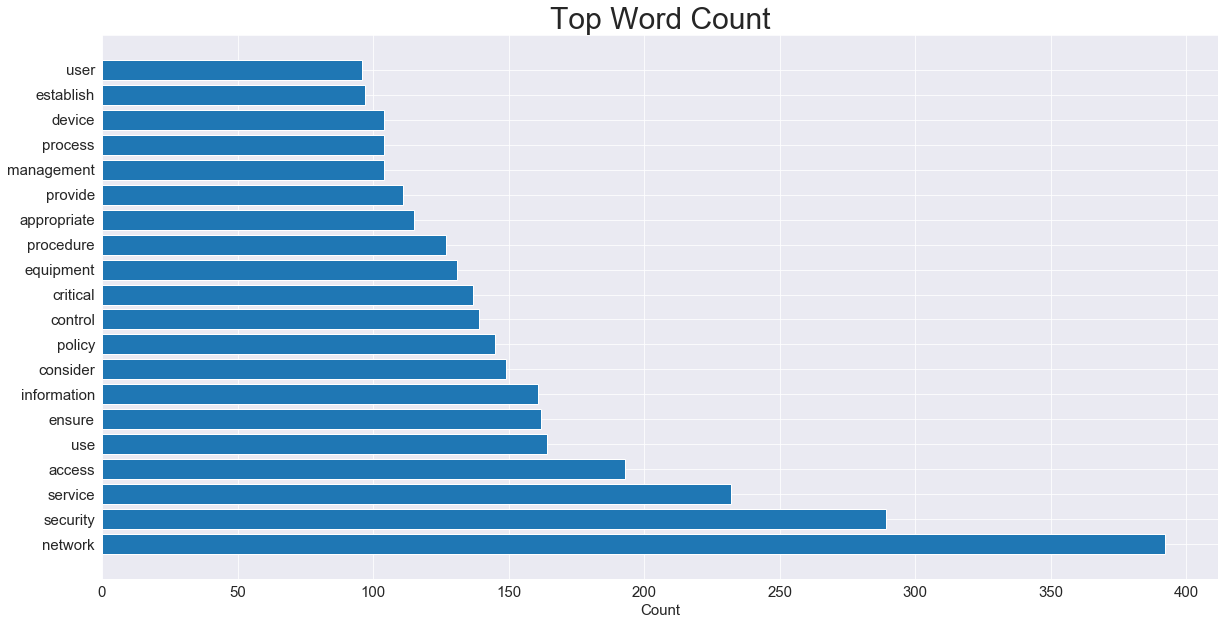

In [15]:
plt.figure(figsize = (20, 10))
plt.barh(y = cv_df_lem.sum().sort_values(ascending = False).head(20).index, width = cv_df_lem.sum().sort_values(ascending = False).head(20))
plt.title('Top Word Count', fontsize = 30)
plt.xlabel('Count', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

### Stemming

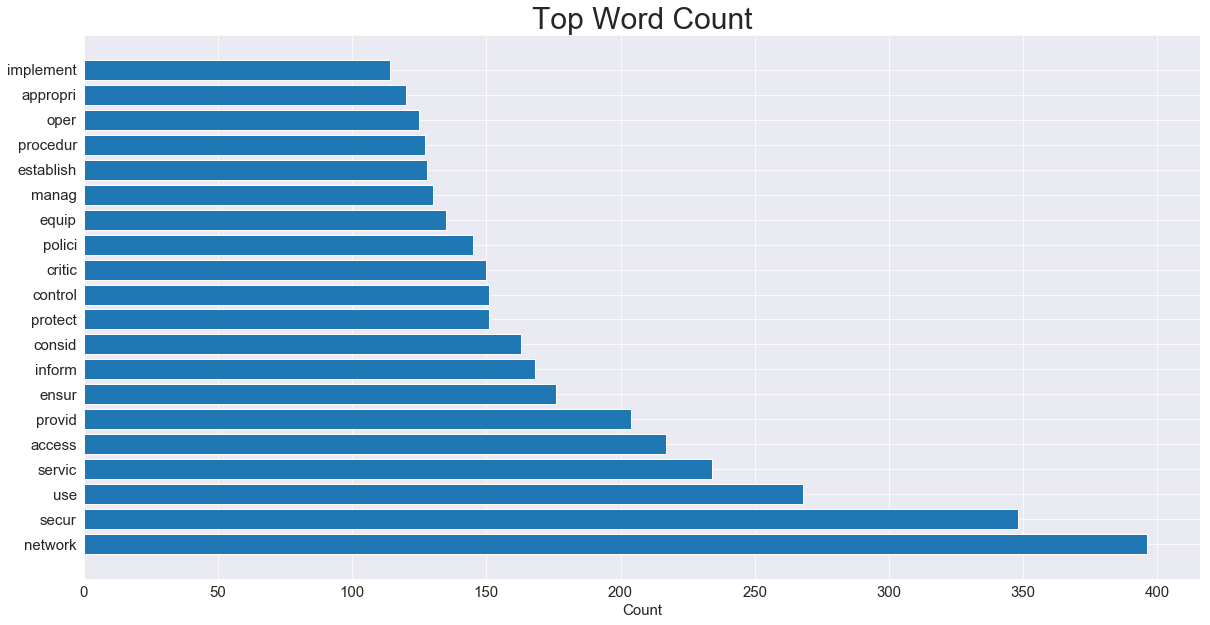

In [16]:
# This is the same thing we did above, but for stemmed words.
cv_stem = CountVectorizer(stop_words = 'english', ngram_range = (1,2), min_df = 25, max_df = .95)
cv_df_stem = pd.SparseDataFrame(cv_stem.fit_transform(processed['stemmed']), columns = cv_stem.get_feature_names())
cv_df_stem.fillna(0, inplace = True)

plt.figure(figsize = (20, 10))
plt.barh(y = cv_df_stem.sum().sort_values(ascending = False).head(20).index, width = cv_df_stem.sum().sort_values(ascending = False).head(20))
plt.title('Top Word Count', fontsize = 30)
plt.xlabel('Count', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

## Modeling: Logisitic Regression

In [17]:
# Let's view the processed dataframe.
processed.head()

,BP Number,Priority,Description,Network Type(s),Industry Role(s),Keywords,Reference,cable,internet/Data,satellite,...,Service Provider,Network Operator,Priorities,Equipment Supplier,Property Manager,Government,Public Safety,tokenized,lemmatized,stemmed
0,11-10-0404,Important,", , , and should incorporate methodologie...",Cable; Internet/Data; Satellite; Wireless; Wir...,Equipment Supplier; Network Operator; Service ...,Hardware; Network Design; Network Elements; Ne...,None,True,True,True,...,True,True,0,True,False,False,True,and should incorporate methodologies that cont...,and should incorporate methodology that contin...,and should incorpor methodolog that continu im...
1,11-10-0407,Highly Important,and should establish processes for NOC-to-...,Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider;,Industry Cooperation; Network Interoperability...,None,True,True,True,...,True,True,1,False,False,False,False,and should establish processes for noc to noc ...,and should establish process for noc to noc ne...,and should establish process for noc to noc ne...
2,11-10-0409,Highly Important,should use virtual interfaces (i.e. a router...,Internet/Data;,Service Provider;,Network Design; Network Elements;,None,False,True,False,...,True,False,1,False,False,False,False,should use virtual interfaces i e a router loo...,should use virtual interface i e a router loop...,should use virtual interfac i e a router loopb...
3,11-10-0411,Highly Important,", , and should consider developing and imp...",Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider; Public Saf...,Network Operations; Facilities - Transport;,None,True,True,True,...,True,True,1,False,False,False,True,and should consider developing and implementin...,and should consider developing and implementin...,and should consid develop and implement cabl l...
4,11-10-0418,Highly Important,", , and should, where appropriate, have a ...",Cable; Internet/Data; Satellite; Wireless; Wir...,Network Operator; Service Provider; Public Saf...,Network Operations; Procedures;,Note: This Best practice could impact 9-1-1 op...,True,True,True,...,True,True,1,False,False,False,True,and should where appropriate have a documented...,and should where appropriate have a documented...,and should where appropri have a document back...


In [18]:
# Here's our columns for the processed dataframe.
processed.columns

Index(['BP Number', 'Priority', 'Description', 'Network Type(s)',
       'Industry Role(s)', 'Keywords', 'Reference', 'cable', 'internet/Data',
       'satellite', 'wireless', 'wireline', 'Service Provider',
       'Network Operator', 'Priorities', 'Equipment Supplier',
       'Property Manager', 'Government', 'Public Safety', 'tokenized',
       'lemmatized', 'stemmed'],
      dtype='object')

In [19]:
# Let's see what our priorities are.
processed['Priorities'].value_counts()

1    548
0    468
Name: Priorities, dtype: int64

In [20]:
X_1 = processed['tokenized']
X_2 = processed['lemmatized']
X_3 = processed['stemmed']
y = processed['Priorities']

In [21]:
y.value_counts(normalize = True)

1    0.53937
0    0.46063
Name: Priorities, dtype: float64

In [22]:
# We're train test splitting 3 different columns.
# These columns are the tokenized, lemmatized & stemmed from the processed dataframe.
X_1_train, X_1_test, y_train, y_test = train_test_split(X_1, y, test_size = 0.3, stratify = y, random_state = 42)
X_2_train, X_2_test, y_train, y_test = train_test_split(X_2, y, test_size = 0.3, stratify = y, random_state = 42)
X_3_train, X_3_test, y_train, y_test = train_test_split(X_3, y, test_size = 0.3, stratify = y, random_state = 42)

## Countvectorize Logistic Regression in a Pipeline

In [23]:
pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression())
])

params = {
    'lr__C':[0.6, 1, 1.2],
    'lr__penalty':["l1", "l2"],
    'cv__max_features':[None, 750, 1000, 1250],
    'cv__stop_words':['english', None],
    'cv__ngram_range':[(1,1), (1,4)]
}

### Pipeline the Tokenized

In [24]:
# Our Logistic Regression Model.
gs_lr_tokenized_cv = GridSearchCV(pipe_cv, param_grid = params, cv = 5)
gs_lr_tokenized_cv.fit(X_1_train, y_train)
gs_lr_tokenized_cv.score(X_1_train, y_train)

0.9746835443037974

In [25]:
gs_lr_tokenized_cv.score(X_1_test, y_test)

0.6754098360655738

In [26]:
gs_lr_tokenized_cv.best_params_

{'cv__max_features': 1250,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': 'english',
 'lr__C': 0.6,
 'lr__penalty': 'l2'}

In [27]:
coefs = gs_lr_tokenized_cv.best_estimator_.steps[1][1].coef_

words = pd.DataFrame(zip(cv.get_feature_names(), np.exp(coefs[0])))

words = words.sort_values(1)

<BarContainer object of 58 artists>

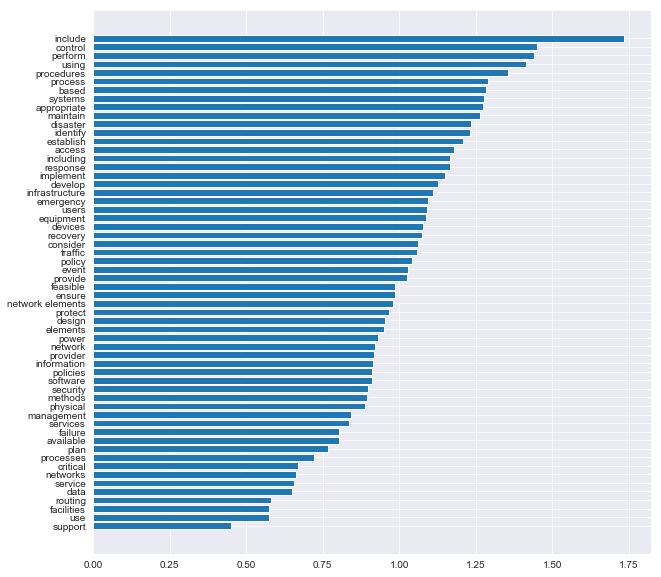

In [28]:
plt.figure(figsize=(10,10))
plt.barh(words[0], words[1])

### Pipeline the Lemmatized

In [29]:
# Our Logistic Regression Model in a lemmatized pipeline for countvectorize.
gs_lr_lemmatized_cv = GridSearchCV(pipe_cv, param_grid = params, cv = 5)
gs_lr_lemmatized_cv.fit(X_2_train, y_train)
gs_lr_lemmatized_cv.score(X_2_train, y_train)

0.9887482419127989

In [30]:
gs_lr_lemmatized_cv.score(X_2_test, y_test)

0.6721311475409836

### Pipeline the Stemmed

In [31]:
# Our Logistic Regression Model in a stemmed pipeline for countvectorize.
gs_lr_stemmed_cv = GridSearchCV(pipe_cv, param_grid = params, cv = 5)
gs_lr_stemmed_cv.fit(X_3_train, y_train)
gs_lr_stemmed_cv.score(X_3_train, y_train)

0.9760900140646976

In [32]:
gs_lr_stemmed_cv.score(X_3_test, y_test)

0.6557377049180327

## TFIDF Vectorize Logistic Regression in a Pipeline

In [33]:
pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

tfidf_params = {
    'lr__C':[.1, 1, 5],
    'lr__penalty':["l1", "l2"],
    'tfidf__max_features':[None, 500, 1000, 1500],
    'tfidf__stop_words':['english', None],
    'tfidf__ngram_range':[(1,1), (1,2)]
}

### Pipeline the Tokenized

In [34]:
# Our Logistic Regression Model in a tokenized pipeline.
gs_lr_tokenized_tfidf = GridSearchCV(pipe_tfidf, param_grid = tfidf_params, cv = 5)
gs_lr_tokenized_tfidf.fit(X_1_train, y_train)
gs_lr_tokenized_tfidf.score(X_1_train, y_train)

0.9578059071729957

In [35]:
# This scores our model for the tokenized tfidf logistic model.
gs_lr_tokenized_tfidf.score(X_1_test, y_test)

0.6688524590163935

### Pipeline the Lemmatized

In [36]:
# Our Logistic Regression Model in a lemmatized pipeline.
gs_lr_lemmatized_tfidf = GridSearchCV(pipe_tfidf, param_grid = tfidf_params, cv = 5)
gs_lr_lemmatized_tfidf.fit(X_2_train, y_train)
gs_lr_lemmatized_tfidf.score(X_2_train, y_train)

0.9718706047819972

In [37]:
# This scores our model for the lemmatized tfidf logistic model.
gs_lr_lemmatized_tfidf.score(X_2_test, y_test)

0.6655737704918033

### Pipeline the Stemmed

In [38]:
# Our Logistic Regression Model in a stemmed pipeline.
gs_lr_stemmed_tfidf = GridSearchCV(pipe_tfidf, param_grid = tfidf_params, cv = 5)
gs_lr_stemmed_tfidf.fit(X_3_train, y_train)
gs_lr_stemmed_tfidf.score(X_3_train, y_train)

0.8846694796061885

In [39]:
# This scores our model for the stemmed tfidf logistic model.
gs_lr_stemmed_tfidf.score(X_3_test, y_test)

0.639344262295082

## Countvectorize Random Forest in a Pipeline

In [40]:
rf_pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__min_samples_split':[7],
    'rf__random_state':[42],
    'cv__max_features':[None],
    'cv__stop_words':['english', None],
    'cv__ngram_range':[(1,1), (1,4)]
}

In [41]:
gs_rf = GridSearchCV(rf_pipe_cv, param_grid = params, return_train_score = True, cv = 5)
gs_rf.fit(X_1_train, y_train)
gs_rf.score(X_1_train, y_train)

0.9578059071729957

In [42]:
gs_rf.score(X_1_test, y_test)

0.6459016393442623

In [43]:
gs_rf.best_params_

{'cv__max_features': None,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': None,
 'rf__min_samples_split': 7,
 'rf__random_state': 42}

## Countvectorize Naive Bayes in a Pipeline

In [44]:
mnb_pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('mnb', MultinomialNB())
])

params = {
    'mnb__alpha':[2.0],
    'cv__max_features':[None],
    'cv__stop_words':['english', None],
    'cv__ngram_range':[(1,1), (1,2)]
}

In [45]:
gs_mnb = GridSearchCV(mnb_pipe_cv, param_grid = params, return_train_score = True, cv = 5)
gs_mnb.fit(X_1_train, y_train)
gs_mnb.score(X_1_train, y_train)

0.9156118143459916

In [46]:
gs_mnb.score(X_1_test, y_test)

0.6524590163934426

In [47]:
gs_mnb.best_params_

{'cv__max_features': None,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': 'english',
 'mnb__alpha': 2.0}

## Visualizations

In [48]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        stopwords = stopwords,
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

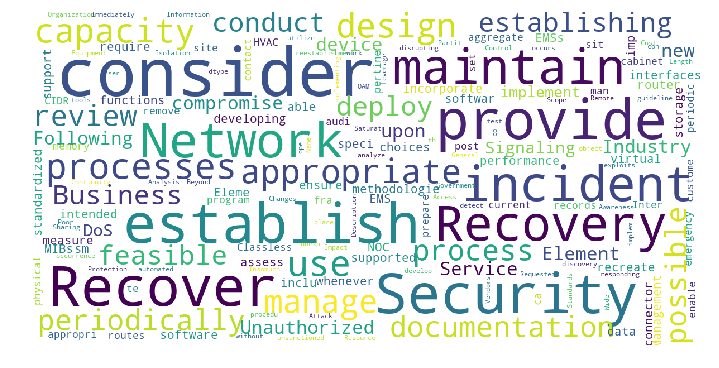

In [49]:
show_wordcloud(fcc_csv['Description'])

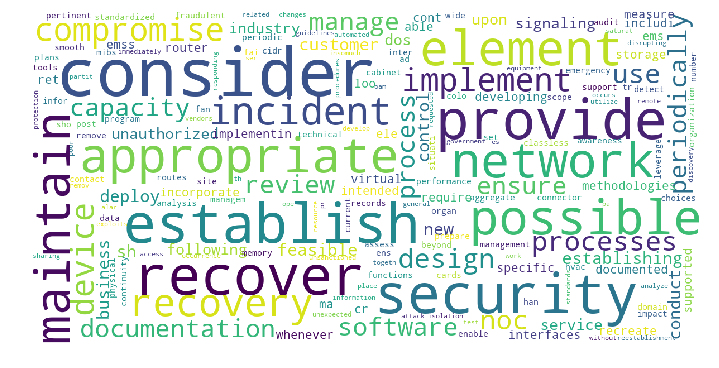

In [50]:
show_wordcloud(processed['tokenized'])

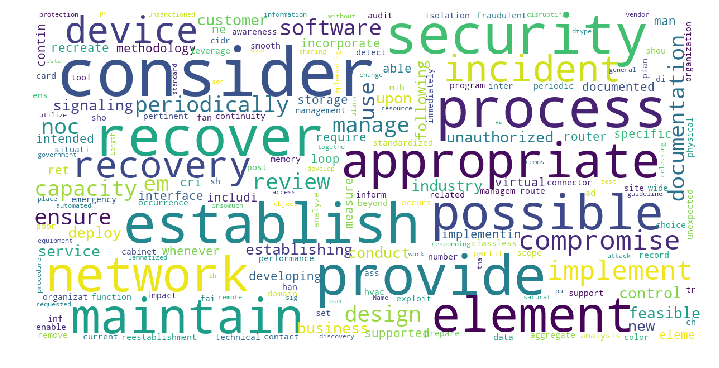

In [51]:
show_wordcloud(processed['lemmatized'])

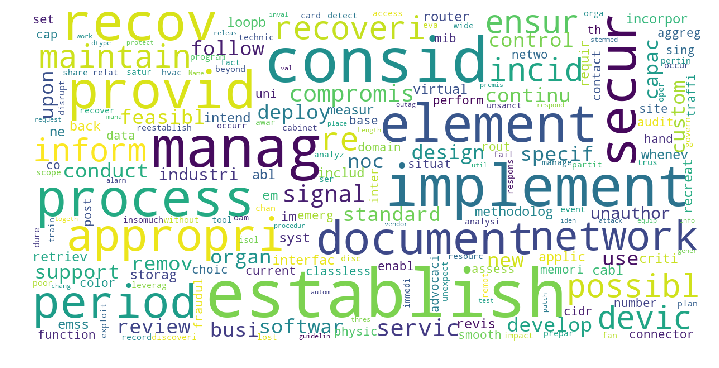

In [52]:
show_wordcloud(processed['stemmed'])